# Introduction

Collection of fundamental statistical methods and tests for quick access. Contents are derived from lecture notebooks prepared by Prof. Felix Valenzuela, simplified and generalized into useful functions for basic statistical analysis. Test inputs are based on sample data in order for the code to run.

In [190]:
# Preliminaries
import numpy as np
import pandas as pd
import powerlaw as pw
import seaborn as sns
import scipy.stats as stats
import statsmodels as sm
import matplotlib.pyplot as plt
import random

from sklearn import datasets
import scipy as sp

from scipy.stats import binom_test
from scipy.stats import norm as gaussian

from scipy.stats import t
from scipy.stats import ttest_1samp
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import levene

%matplotlib inline

# Load Sample Data

In [124]:
df = pd.read_csv('remain_leave.csv')
df.head()

,age,brexit
0,37,1
1,55,1
2,37,1
3,42,1
4,69,1


## Random Sampling from Empirical Distribution

In [125]:
# Random number generator for an empirical distribution.
def empirical_rvs(X, N=1000):
    """
    Generates a distribution of values similar to input X.
    
    Parameters
    ----------
    X : numpy array
    
    N : int
        number of times to randomly sample
    """
    # Generate N random numbers between 0 and 1
    prob = np.random.rand(N)
    # Form the empirical data ppf. We can use scipy.stats.mstats.mquantiles for this.
    eppf = stats.mstats.mquantiles(X, prob)
    return eppf

(array([144., 105., 136., 105., 114., 124., 134.,  87.,  41.,  10.]),
 array([18. , 25.4, 32.8, 40.2, 47.6, 55. , 62.4, 69.8, 77.2, 84.6, 92. ]),
 <a list of 10 Patch objects>)

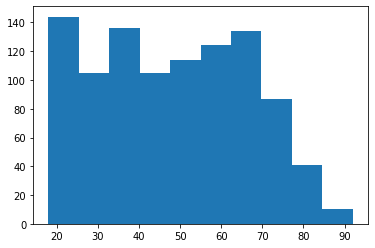

In [126]:
plt.hist(empirical_rvs(df['age']))

# Statistical Tests

## Binomial

In [127]:
def binomial_test(df, target, p=0.5):
    
    classes = df[target].unique()
    dict_class = {}

    for item in classes:
        dict_class[item] = df[df[target]==item]

    sns.countplot(df[target])

    # One-Sided: Null hypothesis is that the "1" fraction is less than half of the population
    result1 = (binom_test(x=len(dict_class[classes[0]]), 
                         n = len(dict_class[classes[0]]) + len(dict_class[classes[1]]), 
                         p=p, alternative="greater"))
    
    # Two-Sided: Null hypothesis is that the "1" fraction is equal to half of the population
    result2 = (binom_test(x=len(dict_class[1]), 
                          n = len(dict_class[classes[0]]) + len(dict_class[classes[1]]),
                          p = p, alternative="two-sided"))
    
    print('one-sided result:', result1)
    print('two-sided result:', result2)

one-sided result: 7.08322657495753e-11
two-sided result: 1.416645314991506e-10


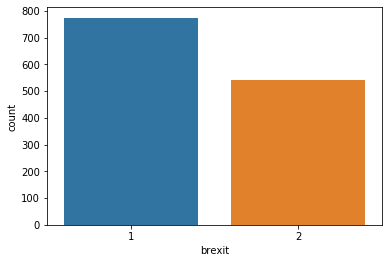

In [128]:
binomial_test(df, 'brexit')

In [129]:
def z_test(df, target, q=0.5):
    
    classes = df[target].unique()
    dict_class = {}

    for item in classes:
        dict_class[item] = df[df[target]==item]
    
    sns.countplot(df[target])
    
    N = len(dict_class[classes[0]]) + len(dict_class[classes[1]])
    q_hat = len(dict_class[classes[0]]) / (len(dict_class[classes[0]]) + len(dict_class[classes[1]]))
    se_qhat = np.sqrt(q * (1.0 - q) / N)
    z_score = (q_hat - q) / se_qhat
    
    # Calculate the p-value using the survival (ccdf) function of the Gaussian distribution:
    p_1side = gaussian.sf(z_score)
    print('one-sided result:', p_1side)

one-sided result: 6.580718753119375e-11


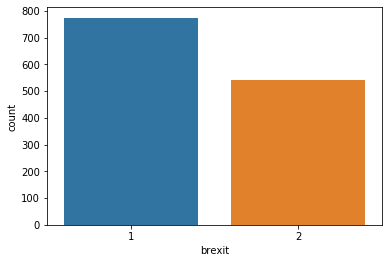

In [130]:
z_test(df, 'brexit')

## Mean of a sample

In [131]:
def t_test(df, feature, value):

    out = df[feature]
    print ("Count:", len(out))
    print ("Average of feature:", np.mean(out))

    t, pval = ttest_1samp(out, value)
    print ("Test statistic:", t, "P<t:", pval/2.0)
    print("P>t:", 1 - pval/2.0)

In [132]:
t_test(df, 'age', 47)

Count: 1315
Average of feature: 49.53764258555133
Test statistic: 5.075923338002219 P<t: 2.2050929271708034e-07
P>t: 0.9999997794907073


# Test Between Two Population Means


In [133]:
# test the hypothesis that the mean age of 'Remain' voters 
# is lower than that of the 'Leave' voters, under \alpha = 0.05.
# Some code: credits to https://matthew-brett.github.io

votes_in = df[df['brexit'] == 1]
votes_out = df[df['brexit'] == 2]

in_ages = list(votes_in["age"])
out_ages = list(votes_out["age"])

In [138]:
def permutation_test(list1, list2):
    """
    Parameters
    ----------
    list1 : list
    
    list2 : list
    """
    alpha = 0.05
    all_ages = list1 + list2
    N_in = len(list1)
    N_out = len(list2)

    # "test statistic"
    delta_obs = np.mean(in_ages) - np.mean(out_ages)
    print("Observed difference in means: ", delta_obs)

    # utility functions
    def difference_in_means(combined_list):
        """ Split shuffled combined group into two, return mean difference"""
        group_in = combined_list[:N_in]
        group_out = combined_list[N_in:]
        return np.mean(group_in) - np.mean(group_out)

    # Number of trials, K
    K = 50000
    deltas = []
    for i in range(K):
        # Shuffle the age data. This is equivalent to randomly reassigning the ages of the voters.
        random.shuffle(all_ages)
        delta_i = difference_in_means(all_ages)
        deltas.append(delta_i)

    # Plot the distribution of the deltas
    sns.distplot(deltas, norm_hist=True,kde=False)
    plt.xlabel("$\Delta$")
    plt.ylabel("Distribution")
    
    num_less_delta_obs = len ([d for d in deltas if d < delta_obs])
    p_val = num_less_delta_obs/K
    print ("p-value:", p_val)

    if p_val < alpha:
        print ("Reject the Null Hypothesis (alpha = %s)"%(alpha,))
    else:
        print ("Fail to Reject the Null Hypothesis (alpha = %s)"%(alpha,))

Observed difference in means:  -3.6998380833655773
p-value: 0.00014
Reject the Null Hypothesis (alpha = 0.05)


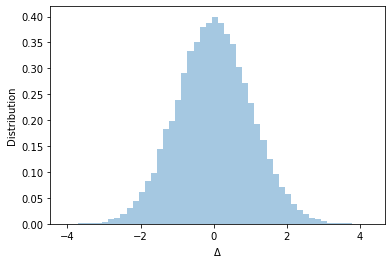

In [139]:
permutation_test(in_ages, out_ages)

In [140]:
def get_proper_pvalue_1tailed(test_statistic, test_tailedness, pval_2tailed):
    '''
        Parameters
        ----------
        `test_statistic` : `float`
            The calculated test statistic.
        `test_tailedness` : `{"less", "greater"}`
            A string indicating whether the test is a left-tailed test (`"less"`)
            or a right-tailed test (`"greater"`).
        `pval_2tailed` : `float`
            The two-tailed p-value reported by a hypothesis-testing function.
            Please check the function's documentation to determine whether it
            reports a one-tailed or a two-tailed p-value.

        Returns
        -------
        `pval_1tailed` : `float`
            The proper one-tailed p-value to use with your one-tailed hypothesis test.
    '''
    # Check if specified test_tailedness is only from the permissible set {"less", "greater"}
    if test_tailedness not in {"less", "greater"}:
        raise ValueError("Specified tail of test must either be 'less' (left-tailed) or 'greater' (right-tailed).")
    
    # Now that's out of the way:
    if test_statistic == 0.0:
        pval_1tailed = 0.5
    if (test_statistic > 0.0 and test_tailedness == "greater") or (test_statistic < 0.0 and test_tailedness == "less"):
        pval_1tailed = 0.5 * pval_2tailed
    if (test_statistic < 0.0 and test_tailedness == "greater") or (test_statistic > 0.0 and test_tailedness == "less"):
        pval_1tailed = 1.0 - 0.5 * pval_2tailed
    return pval_1tailed

In [141]:
def t_test_unpaired(class_mean_0, class_mean_1):
    """
    Parameters
    ----------
    class_mean_0 : list
    
    class_mean_1 : list
    """
    # Define required quantities
    alpha = 0.05
    N1 = len(class_mean_1)
    N2 = len(class_mean_0)
    x1 = np.mean(class_mean_1)
    x2 = np.mean(class_mean_0)
    s1 = np.std(class_mean_1, ddof=1)
    s2 = np.std(class_mean_0, ddof=1)
    V1 = s1*s1/N1
    V2 = s2*s2/N2
    S = np.sqrt(V1 + V2)
    df = int((V1 + V2)**2 / (V1**2 / (N1 - 1) + V2**2 / (N2 - 1)))
    delta_12 = 0.0

    # Compute and display test statistic Remember that we're doing a right-tailed test!
    t_stat = (x1 - x2 - delta_12) / S
    print ("Test statistic: ", t_stat)

    # Shortcut: use ttest_ind. 
    t_stat, p_val = sp.stats.ttest_ind(class_mean_1, class_mean_0, equal_var=False)
    print ("p-value (two-tailed): ", p_val)

    # Since the test is a right-tailed test (see alternative hypothesis above!), we specify "greater" below.
    pval_1tailed = get_proper_pvalue_1tailed(test_statistic=t_stat, test_tailedness="greater", pval_2tailed=p_val)
    print ("p-value (right-tailed): ", pval_1tailed)

In [142]:
t_test_unpaired(in_ages, out_ages)

Test statistic:  3.6836834632783066
p-value (two-tailed):  0.00024021875755525818
p-value (right-tailed):  0.00012010937877762909


In [153]:
choles = pd.read_csv('Session6cFiles/Cholesterol.csv')

In [156]:
def t_test_paired(series1, series2):
    """
    Parameters
    ----------
    series1 : pandas series
    
    series2 : pandas series
    """
    diffs = list(series1 - series2)
    N = len(diffs)
    df = N - 1

    # Average difference and standard deviation
    x_12 = np.mean(diffs)
    s_d = np.std(diffs, ddof=1)

    # Approach 3: shortcut!
    t_stat, p_val = sp.stats.ttest_rel(series1, series2)
    print("Test statistic: ", t_stat)
    print ("p-value (two-tailed): ", p_val)

    # Left-tailed test -> use "less" below.
    pval_1tailed = get_proper_pvalue_1tailed(test_statistic=t_stat, test_tailedness="less", pval_2tailed=p_val)
    print ("p-value (left-tailed): ", pval_1tailed)

In [157]:
t_test_paired(choles["After8weeks"], choles["After4weeks"])

Test statistic:  -3.78090274293469
p-value (two-tailed):  0.0014914189618696698
p-value (left-tailed):  0.0007457094809348349


# Classification Tests

In [171]:
icecream_df = pd.read_csv('Session6cFiles/IceCream.csv')
#  test whether the three flavors *do not* have equal "market share" among high school students.

In [174]:
def chi_sq_test(df, classes):
    """
    Parameters
    ----------
    df : pandas dataframe
    
    classes : str
    """
    series = df[classes]
    N = len(series)

    unique_classes = len(df[classes].unique())

    # Null: equal between classes
    E = [N/unique_classes, N/unique_classes, N/unique_classes]

    # Segment the sample according to flavor preference.
    O = list(series.value_counts())
    chisq, p_val = sp.stats.chisquare(O, E)
    print("Chi-Squared Statistic: %s"%(chisq,))
    print("p-value: %s"%(p_val,))

In [175]:
chi_sq_test(icecream_df, 'ice_cream')

Chi-Squared Statistic: 18.97
p-value: 7.598307042939823e-05


In [184]:
ct = pd.crosstab(icecream_df["female"], icecream_df["ice_cream"])
# For this case, null hypothesis = sex and icecream preference are independent

In [185]:
def chi_sq_independence(ct):
    """
    Parameters
    ----------
    ct : pandas dataframe
        specifically cross-tab of feature and variable of interest
    """
    chi2_stat, p_val, dof, ex = sp.stats.chi2_contingency(ct)
    print("Chi-Squared Statistic: %s"%(chi2_stat,))
    print("p-value: %s"%(p_val,))

In [186]:
chi_sq_independence(ct)

Chi-Squared Statistic: 4.57653239842952
p-value: 0.10144219001975929


# One-Way Analysis of Variance (One-Way ANOVA)

In [202]:
tomato_df = pd.read_csv("Session6cFiles/Tomato1.csv")
# Segment the root dead weight according to Genotype
genotypes = tomato_df.groupby("Genotype")
m82 = genotypes.get_group("M82")["RootDwt"]
line_a = genotypes.get_group("Line A")["RootDwt"]
line_b = genotypes.get_group("Line B")["RootDwt"]

In [203]:
def one_way_anova(class_a, class_b, class_c):
    # Test for equal variances
    # Brown-Forsythe test uses the median (Levene test proper uses the mean)
    W, p_brown_forsythe = levene(class_a, class_b, class_c, center="median")
    print ("Brown-Forsythe p-value: ", p_brown_forsythe)

    alpha = 0.05
    if p_brown_forsythe > alpha:
        print ("Fail to reject the null hypothesis of equal variances.")
        print ("Can go ahead with One-Way ANOVA.")

        f_stat, p_value = f_oneway(class_a, class_b, class_c)
        print("F-statistic: %s; p-value: %s"%(f_stat, p_value))
    else:
        print ("Reject the null hypothesis of equal variances.")
        print ("Cannot go ahead with One-Way ANOVA.")

In [204]:
one_way_anova(m82, line_a, line_b)

Brown-Forsythe p-value:  0.6124985914548331
Fail to reject the null hypothesis of equal variances.
Can go ahead with One-Way ANOVA.
F-statistic: 8.297734116849748; p-value: 0.0009185239581270862
